# Spectral fitting example (GRB)

**To run this, you need the detector response (FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5), binned data (grb_bkg_binned_data.hdf5, grb_binned_data.hdf5, & bkg_binned_data_full.hdf5), and orientation file (20280301_first_2hrs.ori) saved in cosipy/cosipy/test_data. These files can be found on the COSI Pipeline Google Drive.**

**Steps for binning data from .tra files are at the bottom.**

This notebook fits the spectrum of a GRB simulated using MEGAlib and combined with background which is constant in time.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Band function:

$$
f(x) = K \begin{cases} \left(\frac{x}{E_{piv}}\right)^{\alpha} \exp \left(-\frac{(2+\alpha)
       * x}{x_{p}}\right) & x \leq (\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \\ \left(\frac{x}{E_{piv}}\right)^{\beta}
       * \exp (\beta-\alpha)\left[\frac{(\alpha-\beta) x_{p}}{E_{piv}(2+\alpha)}\right]^{\alpha-\beta}
       * &x>(\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \end{cases}
$$


where $K$ (normalization), $\alpha$ & $\beta$ (spectral indeces), and $x_p$ (peak energy) are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha, \beta, x_p]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [13]:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

## Read in binned data

Read in the spacecraft orientation file & select the beginning and end times of the GRB

In [14]:
ori = SpacecraftFile.parse_from_file(test_data.path / "20280301_first_2hrs.ori")
tmin = Time(1835481433.0,format = 'unix')
tmax = Time(1835481435.0,format = 'unix')
sc_orientation = ori.source_interval(tmin, tmax)

Create BinnedData objects for the GRB only, GRB+background, and background only. The GRB only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [15]:
grb = BinnedData(test_data.path / "grb.yaml")
grb_bkg = BinnedData(test_data.path / "grb.yaml")
bkg = BinnedData(test_data.path / "background.yaml")

Load binned .hdf5 files

In [16]:
grb.load_binned_data_from_hdf5(binned_data=test_data.path / "grb_binned_data.hdf5")
grb_bkg.load_binned_data_from_hdf5(binned_data=test_data.path / "grb_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data=test_data.path / "bkg_binned_data_full.hdf5")

Define the path to the detector response

In [17]:
dr = str(test_data.path / "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5") # path to detector response

## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [18]:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    2.8e-4,                                                   # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = grb_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),    # data (source+background)
                bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                sc_orientation = sc_orientation,                              # spacecraft orientation
                nuisance_param = bkg_par)                                     # background parameter

Define a point source at the known location with a Band function spectrum and add it to the model

In [19]:
l = 51.
b = -17.

alpha = -1.                                        # Setting parameters to something reasonable helps the fitting to converge
beta = -3.
xp = 1000 * u.keV
piv = 500 * u.keV
K = 0.00247 / u.cm / u.cm / u.s / u.keV

spectrum = Band(alpha=alpha,
                beta=beta,
                xp=xp.value,
                K=K.value,
                piv=piv.value)

spectrum.xp.unit = xp.unit
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)                              # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Now converting to the Spacecraft frame...
Conversion completed!


Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [20]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

14:54:02 INFO      set the minimizer to minuit                                             ]8;id=312227;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337767;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log



14:54:08 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=38091;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=930388;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.67 -0.09 +0.10) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-6.98 +/- 0.33) x 10^-1,
source.spectrum.main.Band.xp,(1.004 -0.023 +0.024) x 10^3,keV
source.spectrum.main.Band.beta,-2.45 +/- 0.05,
background_cosi,(3.174 +/- 0.025) x 10^-4,


Correlation matrix:

1.00,0.95,-0.94,0.51,0.03
0.95,1.00,-0.84,0.42,0.18
-0.94,-0.84,1.00,-0.63,-0.02
0.51,0.42,-0.63,1.00,0.01
0.03,0.18,-0.02,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-42410.316355
total,-42410.316355


Values of statistical measures:

,statistical measures
AIC,-84822.632709
BIC,-84820.632709


(                                       value  negative_error  positive_error  \
 source.spectrum.main.Band.K         0.002669       -0.000093        0.000098   
 source.spectrum.main.Band.alpha    -0.697615       -0.033040        0.031971   
 source.spectrum.main.Band.xp     1003.777476      -23.741788       23.274700   
 source.spectrum.main.Band.beta     -2.448756       -0.051706        0.052372   
 background_cosi                     0.000317       -0.000003        0.000002   
 
                                      error             unit  
 source.spectrum.main.Band.K       0.000096  1 / (cm2 keV s)  
 source.spectrum.main.Band.alpha   0.032505                   
 source.spectrum.main.Band.xp     23.508244              keV  
 source.spectrum.main.Band.beta    0.052039                   
 background_cosi                   0.000003                   ,
        -log(likelihood)
 cosi      -42410.316355
 total     -42410.316355)

## Error propagation and plotting

Define Band function spectrum injected into MEGAlib

In [21]:
alpha_inj = -1.
beta_inj = -3.
E0_inj = 1000. * u.keV 
K_inj = 5. / u.cm / u.cm / u.s / u.keV             
Emin_inj = 10. * u.keV
Emax_inj = 5000. * u.keV

spectrum_inj = Band_Eflux(alpha=alpha_inj,
                          beta=beta_inj,
                          E0=E0_inj.value,
                          K=K_inj.value,
                          a=Emin_inj.value,
                          b=Emax_inj.value)

spectrum_inj.E0.unit = E0_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.a.unit = Emin_inj.unit
spectrum_inj.b.unit = Emax_inj.unit

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [22]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.67 -0.09 +0.10) x 10^-3,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,(-6.98 +/- 0.33) x 10^-1,
source.spectrum.main.Band.xp,(1.004 -0.023 +0.024) x 10^3,keV
source.spectrum.main.Band.beta,-2.45 +/- 0.05,
background_cosi,(3.174 +/- 0.025) x 10^-4,


Correlation matrix:

1.00,0.95,-0.94,0.51,0.03
0.95,1.00,-0.84,0.42,0.18
-0.94,-0.84,1.00,-0.63,-0.02
0.51,0.42,-0.63,1.00,0.01
0.03,0.18,-0.02,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-42410.316355
total,-42410.316355


Values of statistical measures:

,statistical measures
AIC,-84822.632709
BIC,-84820.632709


None
  * source (point source):
    * position:
      * l:
        * value: 51.0
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -17.0
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Band:
          * K:
            * value: 0.002668934589726522
            * desc: Differential flux at the pivot energy
            * min_value: 1.0e-99
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * alpha:
            * value: -0.69761536655642
            * desc: low-energy photon index
            * min_value: -1.5
            * max_value: 3.0
            * unit: ''
            * is_normalization: false
          * xp:
            * value: 1003.7774760386509
      

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [23]:
energy = np.geomspace(100*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = grb.binned_data.axes['Em'].edges
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

with FullDetectorResponse.open(dr) as response:
    drm = response.get_interp_response(SkyCoord(lon = 51.*u.deg, lat = -17.*u.deg, frame = SpacecraftFrame()))
    dwell_time_map = cosi._get_dwell_time_map(source.position.sky_coord)
    psr = response.get_point_source_response(dwell_time_map)
    
expectation = psr.get_expectation(spectrum)

Now converting to the Spacecraft frame...
Conversion completed!


Plot the fitted and injected spectra

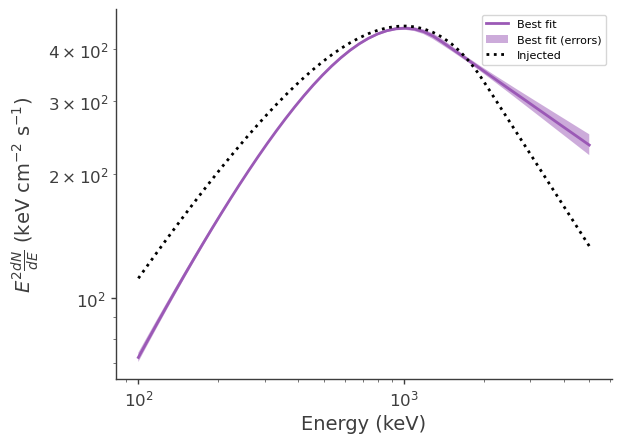

In [24]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()

Plot the fitted spectrum convolved with the response, as well as the simulated source counts

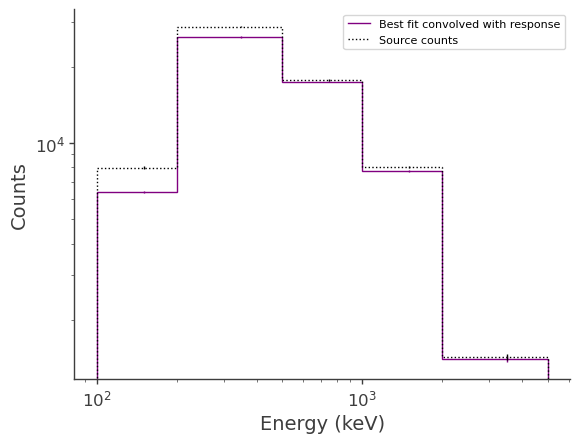

In [25]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, grb.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

Plot the fitted spectrum convolved with the response plus the fitted background, as well as the simulated source+background counts

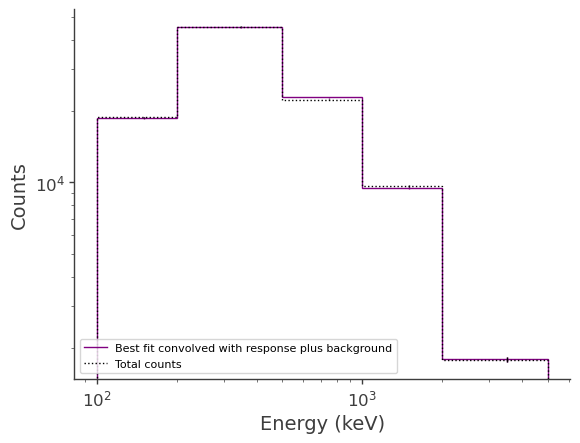

In [26]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, grb_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

## Bin data from .tra files

Read in .tra files for the GRB & background

In [27]:
# grb.read_tra(output_name=test_data.path / "grb_unbinned_data")
# bkg.read_tra(output_name=test_data.path / "bkg_unbinned_data")

Combine unbinned GRB & background .hdf5 files. This does not need to be done if you already have a combined .hdf5 file

In [28]:
# grb_bkg.combine_unbinned_data([test_data.path / "grb_unbinned_data.hdf5",test_data.path / "bkg_unbinned_data.hdf5"], output_name=test_data.path / "grb_bkg_unbinned_data")

Apply time cuts (as defined in .yaml files) to unbinned .hdf5 files for GRB only, GRB+background, and background only

In [29]:
# grb.select_data(unbinned_data=test_data.path / "grb_unbinned_data.hdf5", output_name=test_data.path / "grb_selected_unbinned_data")
# grb_bkg.select_data(unbinned_data=test_data.path / "grb_bkg_unbinned_data.hdf5", output_name=test_data.path / "grb_bkg_selected_unbinned_data")
# bkg.select_data(unbinned_data=test_data.path / "bkg_unbinned_data.hdf5", output_name=test_data.path / "bkg_selected_unbinned_data")

Bin (as defined in .yaml files) GRB only, GRB+background, and background only files

In [30]:
# grb.get_binned_data(unbinned_data=test_data.path / "grb_selected_unbinned_data.hdf5", make_binning_plots=True, output_name=test_data.path / "grb_binned_data", psichi_binning="local")
# grb_bkg.get_binned_data(unbinned_data=test_data.path / "grb_bkg_selected_unbinned_data.hdf5", make_binning_plots=True, output_name=test_data.path / "grb_bkg_binned_data", psichi_binning="local")
# bkg.get_binned_data(unbinned_data=test_data.path / "bkg_selected_unbinned_data.hdf5", make_binning_plots=True, output_name=test_data.path / "bkg_binned_data", psichi_binning="local")

Create spectra and lightcurves for GRB only, GRB+background, and background only

In [31]:
# grb.get_raw_spectrum(binned_data=test_data.path / "grb_binned_data.hdf5", output_name=test_data.path / "grb_sp")
# grb.get_raw_lightcurve(binned_data=test_data.path / "grb_binned_data.hdf5", output_name=test_data.path / "grb_lc")
# grb_bkg.get_raw_spectrum(binned_data=test_data.path / "grb_bkg_binned_data.hdf5", output_name=test_data.path / "grb_bkg_sp")
# grb_bkg.get_raw_lightcurve(binned_data=test_data.path / "grb_bkg_binned_data.hdf5", output_name=test_data.path / "grb_bkg_lc")
# bkg.get_raw_spectrum(binned_data=test_data.path / "bkg_binned_data.hdf5", output_name=test_data.path / "bkg_sp")
# bkg.get_raw_lightcurve(binned_data=test_data.path / "bkg_binned_data.hdf5", output_name=test_data.path / "bkg_lc")